In this task, you are going to cluster MNIST dataset using a pretrained ResNet 18 model and k-means.

# Load the dataset

Load the MNIST dataset bellow. You can use either `torchvision.datasets.MNIST` or `sklearn.datasets.fetch_openml()` or any other way to load the dataset. Note that you won't need a validation set.

In [1]:
import torch
from typing import Tuple, Iterable, Union, List
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import models
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='dataset', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='dataset', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Get ResNet 18

Instantiate ResNet 18 model (pretrained on imagenet) from `torchvision`'s model zoo.

In [26]:
from torchvision.models import resnet18, ResNet50_Weights

model = models.resnet18(pretrained=True).to(device)
model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Remove the decider layer

Replace the `fc` layer of the resnet with an `Identity` layer so that we use the hidden features of the last layer.

In [27]:
model.fc = nn.Identity().to(device)

# Cluster the data

Use `MiniBatchKMeans` to cluster the MNIST dataset in 64 clusters.

In [28]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=64,random_state=0, batch_size=64, verbose=1)

with torch.no_grad():
    model.eval()
    for x, _ in train_loader:
        y = torch.repeat_interleave(x.to(device), 3, dim=-3)
        z = model(y).cpu().numpy()
        kmeans.partial_fit(z)

[MiniBatchKMeans] Reassigning 2 cluster centers.


# Assign clusters to test set.

Predict cluster for test set samples.

In [29]:
true_labels = []
predictions = []
with torch.no_grad():
    model.eval()
    for x, y in test_loader:
        x_tensor = torch.repeat_interleave(x.to(device), 3, dim=-3)
        predictions.append(kmeans.predict(model(x_tensor).cpu().numpy()))
        true_labels.append(y.numpy())

In [30]:
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

# Draw clusters

Draw 10 random samples per each cluster from the test set.

In [32]:
import random
chosen_indices = []
images = []
for i in range(64):
  indices = np.argwhere(predictions == i)[:, 0]
  temp = random.choices(indices, k=10)
  chosen_indices.append(temp)
  images.append([test_dataset[i][0][0].numpy() for i in temp])

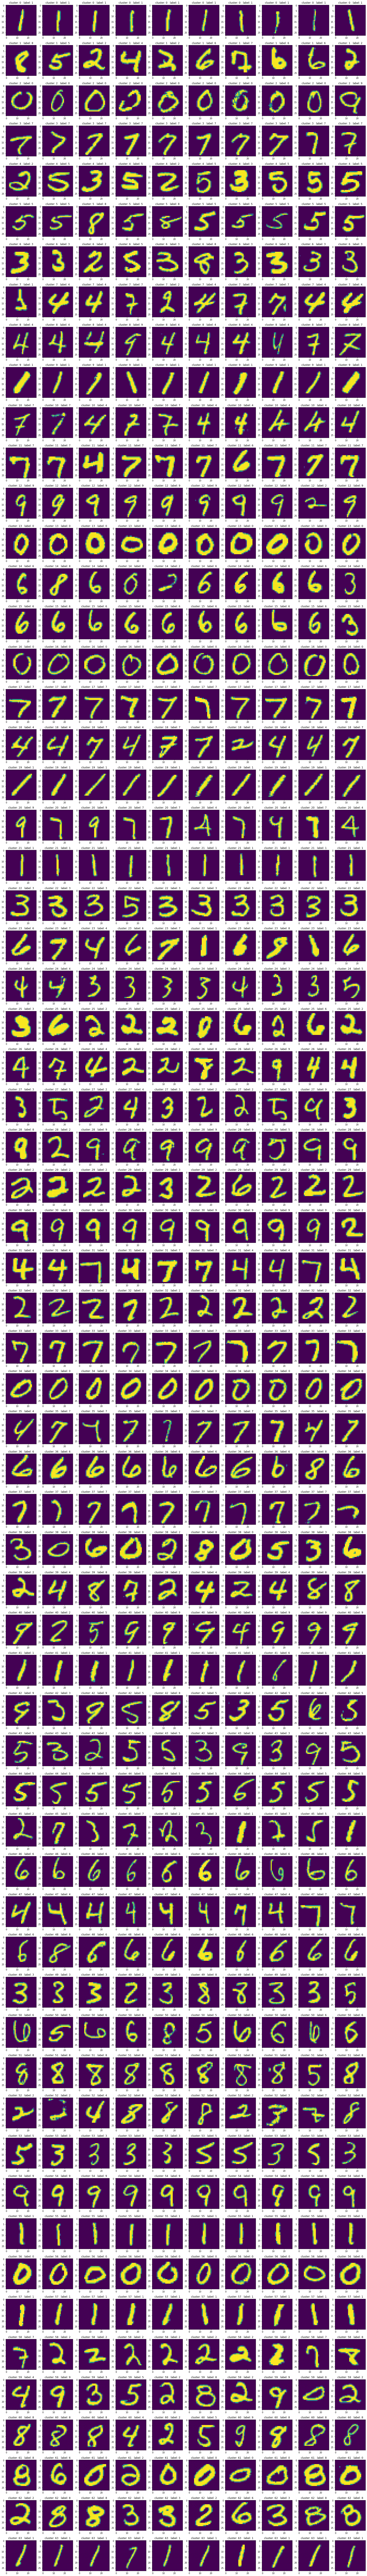

In [43]:
fig, axes = plt.subplots(nrows=64, ncols=10, figsize=(30, 220))
for i, x in enumerate(axes):
  for j, ax in enumerate(x):
      image = images[i][j]
      index = chosen_indices[i][j]
      ax.set_title("cluster: " + str(i) + "   label: "+ str(true_labels[index]))
      ax.imshow(image)
plt.show()